# Agrupamiento de documentos

Autor: Eric S. Tellez <eric.tellez@infotec.mx> <br/>


## Introducción

Hasta el momento hemos visto operaciones de búsqueda de texto completo y de la búsqueda en espacios métricos.
Ambas operaciones son fundamentales en un sistema de recuperación de información, y de hecho, en otras áreas como son la inteligencia computacional.
También se vió la clasificación basada en vecinos cercanos como una herramienta para comparar modelos de texto.

Recordemos que el objetivo de la disciplina de Recuperación de Información es facilitar el acceso a las personas a grandes cúmulos de información, de tal forma que seamos capaces de encontrar la información sobre la que se realizan consultas. En ese espíritu, el agrupamiento (clustering) y la visualización son de gran ayuda para obtener información de valor.

En el agrupamiento se parte una base de datos métrica (documentos o cualquier otro tipo de dato) de tal forma que los elementos en cada una de sus partes tengan cierta afinidad, por ejemplo que sean cercanos y compactos, o que pertenezcan a un grupo donde la densidad sea alta. Normalmente se intenta reducir una función de costo para cada grupo y de manera global.

Recuerde que en la representación basada en bolsas de palabras es común encontrar vectores de decenas o cientos de miles de dimensiones, aunque sumamente dispersos. En las representaciones semánticas se encuentran en espacios densos de cientos de dimensiones. La distancia en ambos casos es comúnmente medida en términos de los ángulos de los vectores, ya que esto nos permité disociar las magnitudes que cambiarán con la cantidad de componentes y con el tamaño de los documentos. Lo último nos da ventajas ya que normalmente se desea recuperar documentos largos a partir de consultas pequeñas. Sin embargo, para tareas como clustering de documentos, dichos supuestos son incorrectos, ya que los vectores son los mismos documentos de un corpus. Esto hace que algunos de los supuestos sobre el funcionamiento de algunos índices sean imprecisos, en particular, el índice invertido no tiene su gran ventaja que sería acceder a unas pocas listas de posteo y el costo sería mucho más elevado que resolver consultas de usuarios.

## Agrupamiento (clustering)

Existen diversos algoritmos de clustering que pueden apoyar en la tarea, todos ellos con diferentes características que lo hacen adecuado para ciertas tareas. En particular, podemos mencionar algunos ejemplos paradigmáticos, como sigue:

- [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering): Intenta encontrar los $k$ centros $C$ que minimicen la suma de las distancias al cuadrado de todos los elementos de la base de datos a algún elemento en $C$. En su forma más simple, el algoritmo comienza con una muestra aleatoria de $k$ puntos y usa el [algoritmo de Lloyd](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) para refinar los $k$ puntos: en cada iteración, se genera una partición con los elementos más cercanos a cada uno de los centroides, y se usan para generar nuevos centroides. El algoritmo convergerá en algunas iteraciones ya que es bastante rápido. Tiene como desventaja que el usuario debe saber el número de grupos $k$ óptimo y que su calidad puede variar de manera dramática con diferentes formas de inicializar el algoritmo.

- [affinity propagation](https://en.wikipedia.org/wiki/Affinity_propagation): Usa tres matrices y un esquema basado en mensajes para obtener los elementos más adecuados para representar una base de datos. En este algoritmo no es necesario especificar $k$ ya que se calcula como parte del proceso. Las tres matrices son, la matriz de similitud, la matriz de reponsabilidad y de de disponibilidad. La idea es considerar a todos los elementos como posibles centros e intercambiar mensajes entre las matrices de responsabilidad y disponibilidad, usando la matriz de similitud como base de la información. El algoritmo es iterativo y se detendrá cuando no haya cambios en las matrices o se llegue a un límite en el número de las iteraciones. La estructura del cluster emergerá como parte este proceso.

- [DBSCAN](https://es.wikipedia.org/wiki/DBSCAN): Es un algoritmo que es especial para descubrir grupos en base a la densidad, de tal forma que para que dos puntos $u$ y $v$ pertenezcan al mismo grupo, no necesariamente son cercanos entre ellos, pero si que hay una serie de puntos $\{w_i\}$ en el mismo grupo con los que se puede trazar una ruta entre $u$ y $v$. Ahora, para que un elemento forme parte de un grupo debe cumplir que comparte al menos $\ell$ elementos en común con el grupo en un radio de búsqueda $\epsilon$, los puntos dentro de una ruta entonces cumplen con estas propiedades. A diferencia de los algoritmos basados en particiones compactas, las formas de los grupos en DBSCAN pueden ser caprichosas. No es necesario conocer el número de centros pero si $\ell$ y $\epsilon$.


In [1]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, 
    StatsBase, Clustering, Plots, LinearAlgebra, HypertextLiteral, JLD2, JSON, DataFrames

  Activating project at `~/Cursos/IR-2024/Unidades`


In [2]:
function create_index(db)
    dist = NormalizedCosineDistance()
    #db = VectorDatabase(vectors)
    index = SearchGraph(; dist, db, verbose=false)
    index!(index)
    optimize!(index, MinRecall(0.9))
    index
end


create_index (generic function with 1 method)

In [3]:
include("read_datasets.jl")

E = let
    corpus, _ = read_news()
    Xtrain = load("data/spanish-twitter-news-and-opinions-top25-68.train--sbert-multi-L12-v2.h5", "emb")::Matrix{Float32}
    index = create_index(MatrixDatabase(Xtrain))
    (; corpus, index)
end

nothing

# Reducción de dimensión

In [4]:
function create_umap_embeddings(index; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
    # layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    # layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

In [5]:
@info Threads.nthreads()
@time e2, e3 = create_umap_embeddings(E.index, k=15, tol=1e-4, layout=RandomLayout());

[ Info: 64


  0.253451 seconds (30.39 k allocations: 4.053 MiB)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.208058585
- embedding init: 0.00034078
- embedding opt: 4.992412536



 19.041377 seconds (9.31 M allocations: 665.016 MiB, 1.14% gc time, 42.49% compilation time)


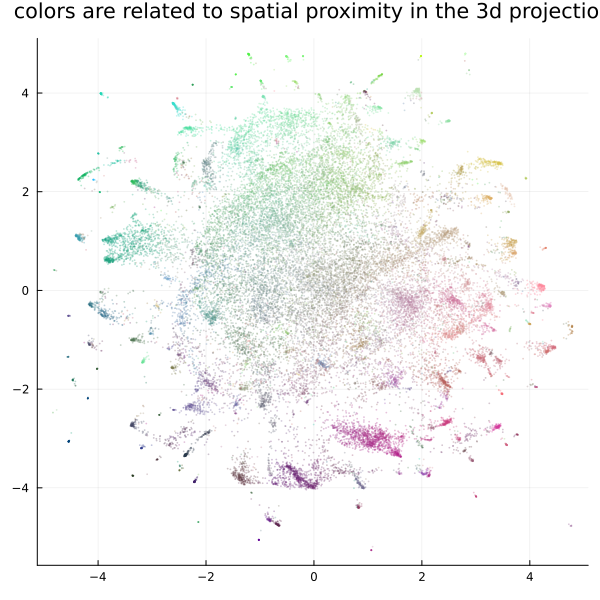

In [6]:
plot_umap(e2, e3)

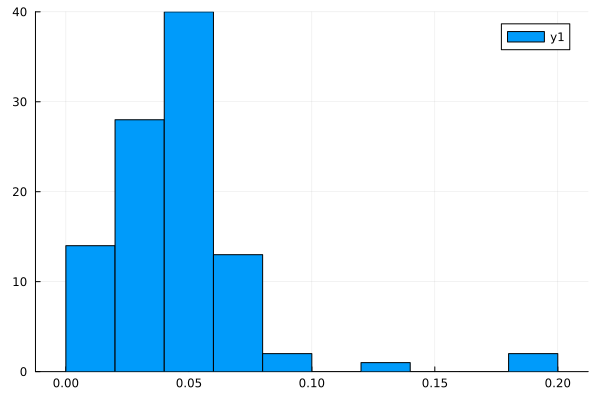

In [7]:
function compute_epsilon(emb; m=100, k=7)
    db = MatrixDatabase(emb)
    E = ExhaustiveSearch(; dist=L2Distance(), db)
    queries = rand(db, m)
    I, D = searchbatch(E, queries, k)
    histogram(last.(eachcol(D)))
end

compute_epsilon(e2)

# Clustering

In [8]:
dbscanresult = dbscan(e2, 0.02, min_cluster_size=20);

In [9]:
length(dbscanresult.clusters)

105

In [10]:
plot()

let res = KnnResult(20)
    bow = Dict{UInt32,Int32}()
    textconfig = TextConfig(group_usr=false, group_url=true, del_diac=false, del_punc=true, lc=false, group_num=true, nlist=[1], qlist=[])
    voc = filter_tokens(Vocabulary(textconfig, E.corpus.text)) do t
        5 <= t.ndocs <= 1000
    end
    
    for c in dbscanresult.clusters
        X = @view e2[1, c.core_indices]
        Y = @view e2[2, c.core_indices]
        scatter!(X, Y, c=:auto, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
        if rand() < 0.3
            L = sort!(collect(countmap(E.corpus.labels[c.core_indices])), by=last, rev=true)
            L = [ "$k ($v); " for (k, v) in L]
            
            empty!(bow)
            S = []
            
            
            for i in c.core_indices
                V = bagofwords(voc, E.corpus.text[i])
                length(V) == 1 && continue  # empty vectors 
                TextSearch.add!(bow, V)
                if length(S) < 7
                    push!(S, @htl """<li>$(E.corpus.text[i])</li>""")
                end
            end
            
            res = reuse!(res)
            for (tokenID, weight) in bow
                push_item!(res, tokenID, -weight)
            end
            
            LV = []
            for p in res
                push!(LV, string(voc.token[p.id], " (", -ceil(Int, p.weight), "); "))
            end
            
            display(@htl """
            <div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
                CLUSTER LABELS ($(length(c.core_indices))): <span style="background-color: rgb(60, 60, 10);">$(L)</span>
            <div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
                VOC: $(LV)
                <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
                <ul> $S </ul>
                </div>
            </div>
            </div>
            """)
            
            # @show C[c.core_indices, :]  # cut text
        end
    end
end


<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (166): <span style="background-color: rgb(60, 60, 10);">el_pais (15); El_Universal_Mx (14); EFEnoticias (13); UniNoticias (13); AristeguiOnline (11); abc_es (11); bbcmundo (10); CNNEE (10); TelemundoNews (9); NTN24 (8); Milenio (8); azucenau (7); SinEmbargoMX (6); PublimetroCol (5); Reforma (5); PublimetroMX (3); PublimetroChile (3); LaRazon_mx (3); AdriDelgadoRuiz (3); RicardoAlemanMx (3); epigmenioibarra (2); teleSURtv (2); abrahamendieta (1); Radio_Formula (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: vacunación (48); vacuna (33); vacunas (30); vacunados (25); personas (24); vacunarse (17); dosis (13); covid0 (12); vacunar (11); están (11); No (10); 💉 (10); mayores (10); 👉 (9); Biden (9); vacunado (9); sin (9); EU (9); anticovid (8); #COVID0 (8); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Esta es la lista de países a los que Estados Unidos donará vacunas anticovid https://t.co/hsB5vbWSOc</li><li>Sanidad insiste en la vacunación para mitigar la gravedad de nuevos contagios.

https://t.co/Uv0vMhXUgI https://t.co/09mb5fbT1E</li><li>Continente americano enfrenta una pandemia de los no vacunados: OPS https://t.co/Mqr94qbhxR https://t.co/f9HhaTFCZO</li><li>El consejero de Salud y Familias, Jesús Aguirre, ha reclamado que &quot;el carné de vacunación sea obligatorio&quot; para &quot;entrar&quot; a determinados espacios públicos, como centros sanitarios, de actividades de ocio nocturno y espectáculos deportivos.

https://t.co/6eC96NCCnn</li><li>Para algunos estadounidenses, la recomendación de dejar de usar mascarilla para los completamente vacunados fue un error que ahora se paga.

https://t.co/fmj2e6k9ZC</li><li>“Es una bendición; nos ayudó mucho”: AMLO asegura en #LaMañanera que hubo presupuesto suficiente para vacunas anticovid porque no hay corrupción https://t.co/o8SLbBlwDD</li><li>Sin explicación alguna, un adulto mayor causó destrozos en un módulo de vacunación anticovid en Tampico, Tamaulipas
#VIDEO 
https://t.co/8MTQZpdEzK</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (51): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (7); El_Universal_Mx (6); CNNEE (6); el_pais (4); UniNoticias (4); LaRazon_mx (3); AdriDelgadoRuiz (3); abc_es (3); bbcmundo (2); EFEnoticias (2); Reforma (2); Radio_Formula (2); TelemundoNews (2); PublimetroCol (1); julioastillero (1); epigmenioibarra (1); Milenio (1); teleSURtv (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: inflación (41); precios (12); Inflación (8); qué (8); están (6); plan (5); desde (5); país (4); consumidores (4); AMLO (4); mayor (4); UU (4); productos (4); 🔴 (4); EE (4); América (3); estadounidenses (3); alto (3); Latina (3); analistas (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Por desgracia, esta tendencia impactará en la elevada inflación y golpeará los presupuestos de las familias estadounidenses. ¿A qué se debe este aumento?
https://t.co/8OnSFQkmJ3</li><li>🔴ÚLTIMA HORA | La inflación cerró el año en el 6,5%, el mayor nivel en casi 30 años. El precio de la luz, las gasolinas y alimentos como el aceite o la carne elevan el coste de la vida https://t.co/ODuoZxlBS6 https://t.co/Zia1UHdV7R</li><li>La secretaria del Tesoro de EE.UU. admitió que falló en anticipar el tiempo que afectaría la alta inflación a los consumidores estadounidenses, mientras el gobierno de Biden trabaja para contener un creciente lastre político. https://t.co/ZyR78dmdcC</li><li>RT @ElUniversal_SLP: 📈 La inflación impacta en costo del tequila, whisky y coñac; dueños de bares y antros descartan aumentar costos para n…</li><li>.@lopezobrador_ detalló que está en pláticas con productores y distribuidores de alimentos para fijar precios justos que ayuden a contener el impacto de la inflación. Los información en #FórmulaDetrásDeLaNoticia con @RicardoRocha_Mx. https://t.co/3aj9fImrLf</li><li>Si continúa la tendencia al alza en la inflación y afecta a productores, invariablemente afectará a los consumidores. 
Escucha a Rodolfo Sánchez Arriola, consultor de temas financieros
#podcast #ElDedoEnLaLLaga
#HeraldoRadio @heraldodemexico https://t.co/d1TXpySnWe</li><li>La inflación podría estar llegando a su pico y hay señales de que los precios podrían bajar pronto, según analistas. https://t.co/VrWENCW7MH</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (40): <span style="background-color: rgb(60, 60, 10);">el_pais (8); abc_es (7); EFEnoticias (6); AristeguiOnline (6); El_Universal_Mx (2); julioastillero (2); LaRazon_mx (2); Reforma (2); SinEmbargoMX (1); PublimetroMX (1); epigmenioibarra (1); Milenio (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: EU (13); UE (8); Europea (7); Europa (6); tras (4); Unión (4); Comisión (3); Gobierno (3); Parlamento (2); año (2); República (2); Gil (2); tan (2); migrantes (2); le (2); 👉 (2); nuevas (2); pero (2); Bajos (2); refugiados (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Demandarán ante tribunales de EU a empresas responsables de la construcción del tramo elevado que se desplomó

https://t.co/phAJwDHQMW</li><li>Marine Le Pen consigue un crédito de un banco húngaro próximo a Orbán para financiar su campaña https://t.co/kEeiqPd76i Por Juan Pedro Quiñonero</li><li>Un agujero de 83.000 millones de euros al año en la UE por culpa de las falsificaciones https://t.co/UgXUUJ7ojf por @TeresaSV</li><li>🚨 #ÚLTIMAHORA | República Checa da la sorpresa y elimina a los Países Bajos de la #Eurocopa2021 https://t.co/ucKQLeALd2 https://t.co/VbRTFn8MEL</li><li>Defensores de los migrantes en EU denuncian la &apos;cruel&apos; política de asilo de Biden 👉 https://t.co/s72rG22cGO https://t.co/KPTFG4wSgr</li><li>Bruselas urge a adoptar las nuevas normas que permitirían regular el mercado de criptodivisas tras el reciente desplome de la moneda estable Terra y para facilitar también aplicar las sanciones a Rusia.

https://t.co/1X8UgCUY2a</li><li>#ÚltimaHora 🚨 Cierran el Pentágono de EU por disparos en estación de Metro cercana https://t.co/DJ5A2Dv1ex https://t.co/tceYnLG2qH</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (103): <span style="background-color: rgb(60, 60, 10);">UniNoticias (27); TelemundoNews (15); EFEnoticias (11); CNNEE (10); AristeguiOnline (9); El_Universal_Mx (5); SinEmbargoMX (4); Milenio (4); NTN24 (3); teleSURtv (3); el_pais (3); LaRazon_mx (2); Reforma (2); PublimetroMX (1); julioastillero (1); AdriDelgadoRuiz (1); Radio_Formula (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: migrantes (47); 🎥 (23); frontera (17); inmigrantes (14); caravana (11); personas (10); desde (10); migrante (9); han (9); Migrantes (9); niños (7); vida (6); Un (6); EU (6); Tapachula (5); son (5); EEUU (5); Migración (4); cruzar (4); Rescatan (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#Opinión | ¿Cómo pudieron tantas personas entrar a México y desplazarse luego hasta la frontera con EU? La respuesta es obvia: con la ayuda de organizaciones criminales especializadas en el contrabando de migrantes, dice @ruizhealy.
https://t.co/a8yBxdJJom https://t.co/dFlEyQRJoo</li><li>México y Estados Unidos anunciaron el miércoles &quot;Sembrando Oportunidades&quot;, una iniciativa conjunta para abordar las causas fundamentales de la migración irregular desde El Salvador, Guatemala y Honduras. https://t.co/U1WYNJET7J</li><li>La caravana migrante está frente al miedo a la muerte y en la mira de un futuro mejor https://t.co/MVt4Vkvxly https://t.co/1RHVzjFkWr</li><li>Una nueva caravana con cerca de 600 migrantes se encuentra a punto de llegar a la frontera estadounidense. 

Estos son los detalles 👇🏻 https://t.co/dvvOLoDCGL</li><li>Miles de inmigrantes hoy sufren por partida doble luego de exponerse removiendo escombros de las torres gemelas.

Sus testimonios 👇🏼

#NeverForget
 https://t.co/cKwbniQ8ru</li><li>&quot;De marzo del año pasado, cuando inició la pandemia de Covid-19, a la fecha, hemos tenido 256 reportes de personas migrantes que desaparecieron al intentar cruzar la frontera&quot;, directora del Programa de Migrantes Desaparecidos y Programa de ADN | #NotaPlus https://t.co/L0bStod7O7</li><li>Para la vicepresidenta &quot;fue horrible&quot; ver a agentes a caballo maltratando a migrantes en la frontera.
https://t.co/TY9dW24zN8</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (25): <span style="background-color: rgb(60, 60, 10);">LaRazon_mx (4); Radio_Formula (4); AristeguiOnline (4); Reforma (3); CNNEE (3); NTN24 (2); Milenio (2); bbcmundo (1); El_Universal_Mx (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: NFL (18); Tom (4); Brady (4); duelo (4); Ángeles (4); #NFL (3); Semana (3); Super (3); Aaron (3); covid0 (3); Bowl (3); Video (3); tras (2); jugador (2); uno (2); #Deportes (2); sede (2); 🚨 (2); ex (2); VIDEO (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🎥 Los Rams se coronan campeones del Super Bowl LVI: fanáticos celebran en el centro de Los Ángeles.

https://t.co/r3IHS36Hj2</li><li>Checa los resultados, crónicas, fotos, jugadas y lo más importante de cada uno de los juegos de la Semana 15 de la NFL

#NFL
#LeeloEnCANCHA #NoctámbulosREFORMA https://t.co/SxTCqGbxsh</li><li>NFL: Así fue el duro tope de carnero a Budda Baker en el SoFi Stadium | Video https://t.co/BSgaaTTbo3</li><li>RT @Vive_USA: El mariscal de campo de los Chiefs ha superado varios récords de estrellas de la NFL como Tom Brady, Aaron Rodgers, y Peyton…</li><li>🎙️Hoy en #ElCaféDeLaMañanaPódcast: La NFL en datos

Comenzó la temporada de futbol americano, uno de los negocios más exitosos y equitativos, @PabloPenaMunoz platicó con @apchavira y @alfredolecona para conocer más de estos datos https://t.co/kVU1FE6FXm</li><li>Carl Nassib, el primer jugador en activo de la NFL en declararse gay https://t.co/hJaxgVsNFN</li><li>🚨#ÚLTIMAHORA |Tom Brady anuncia su regreso a la NFL; jugará con Tampa. https://t.co/eU7VvDmGps https://t.co/V5vgQUHAWC</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (102): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (13); abc_es (9); El_Universal_Mx (8); Milenio (7); RicardoAlemanMx (6); Radio_Formula (6); UniNoticias (6); TelemundoNews (6); LaRazon_mx (5); teleSURtv (5); SinEmbargoMX (4); Reforma (4); PublimetroChile (3); epigmenioibarra (3); bbcmundo (3); CNNEE (3); EFEnoticias (3); el_pais (3); PublimetroMX (2); julioastillero (1); azucenau (1); AdriDelgadoRuiz (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: gas (27); gasolina (26); precio (25); LP (21); precios (19); Gas (14); petróleo (12); combustible (10); 👉 (9); Bienestar (9); $ (8); mil (6); demanda (6); está (6); barril (6); qué (6); semana (6); aumento (6); 🇺 (5); litro (5); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Precio del gas LP: Conoce los costos del combustible en México para la semana del 26 de junio al 2 de julio.     https://t.co/r5xdkVf1Hc</li><li>El precio del gas LP ha aumentado en un año casi 30 %, lo que ha resultado en un mayor gasto para los consumidores y en ganancias para las empresas, en especial para las nueve que controlan el mercado en México, de acuerdo con datos de la CRE y la Profeco https://t.co/oa0OeXyGo5 https://t.co/zmevRdKlyn</li><li>El precio del petróleo #Brent alcanzó el precio de 108.44 dólares por barril,  siendo la cifra más alta del crudo registrada desde agosto del año 2014 https://t.co/oPK9RY0eIJ</li><li>Este es el precio de la gasolina en CDMX.
https://t.co/fPsh5WTpaZ</li><li>El ministro de Comercio de #Haití 🇭🇹 desmintió un alza en los precios de combustibles, luego que las estaciones de gasolina experimentaran una alta demanda a causa del rumor https://t.co/EiO3QNEfzd</li><li>El acuerdo alcanzado entre Gobierno y transportistas de mercancías por carretera rebaja el precio del carburante en 20 céntimos por litro y promete aplicar al sector los principios de la ley de la cadena alimentaria.

https://t.co/kQjeYrLHMI</li><li>Estos son los precios del gas LP del 24 al 30 de abril | Lista completa
https://t.co/YVWbbnpXE7</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (20): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (6); epigmenioibarra (2); AristeguiOnline (2); NTN24 (1); El_Universal_Mx (1); PublimetroCol (1); Milenio (1); bbcmundo (1); abrahamendieta (1); teleSURtv (1); el_pais (1); AdriDelgadoRuiz (1); Radio_Formula (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: 👇 (4); Chile (4); apoyar (3); Kast (3); señor (3); le (3); podemos (3); mundo (3); José (2); siempre (2); No (2); 👉 (2); López (2); todo (2); @jairocalixto (2); estaba (2); Calderón (2); vivo (2); escrutadas (2); Antonio (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @YedraDs: @epigmenioibarra No cabe duda que el expresidente Calderón, se hace que la virgen le habla, pero todos los elementos apuntan a…</li><li>El ermitaño que lleva 40 años viviendo en un bosque apartado del mundo https://t.co/sXAZqmu36X</li><li>#ChileDecide | Con más de 33.501 mesas escrutadas de un total de 46.887, correspondiente a 71,45%

José Antonio Kast: 28,30%

Gabriel Boric: 24,07%

Franco Parisi Fernández: 13,31%

Yasna Provoste Campillay: 12,00%

Síguelo aquí ➡https://t.co/tqMKHfl0b4 https://t.co/ax5zfn8RRF</li><li>¿Por qué se dice que #AntonioLópezdeSantaAna fue un “chivo expiatorio” y siempre fue el “malo de la #pelicula”?
Escucha al profesor Francisco Mendoza, #historiador #narrador en @UruzRadio
#ElDedoEnLaLlaga @heraldodemexico #historia https://t.co/tr0kjXbo6R</li><li>#LaMañaneraDeAMLO “Deseo que Joaquín López-Dóriga viva mucho tiempo, larga vida”, expresa López Obrador al confundir al periodista con “el finado” Jacobo Zabludovsky https://t.co/1nn2hruyAK https://t.co/jA4BzMDZiV</li><li>Radicado en estados Unidos y más calmado, cuenta que vendrá a Chile «de visita» a dar shows en octubre.

https://t.co/5TSJFPevGD</li><li>Pobre Marko Cortés, estaba 100% seguro de que el PAN iba a perder todo, menos Aguascalientes, y se le está complicando más de lo esperado. 

¡El PRIAN lo perderá TODO! ¡@Nora_Ruvalcaba será gobernadora! https://t.co/1AZTajiFCU</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (115): <span style="background-color: rgb(60, 60, 10);">teleSURtv (25); EFEnoticias (12); bbcmundo (10); NTN24 (9); abrahamendieta (6); RicardoAlemanMx (6); UniNoticias (6); CNNEE (5); abc_es (5); TelemundoNews (5); El_Universal_Mx (4); Milenio (3); AdriDelgadoRuiz (3); PublimetroChile (2); epigmenioibarra (2); Reforma (2); el_pais (2); AristeguiOnline (2); Radio_Formula (2); PublimetroMX (1); PublimetroCol (1); julioastillero (1); azucenau (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Cuba (63); 🇺 (27); #Cuba (27); 🇨 (22); cubano (18); régimen (14); cubanos (14); gobierno (13); país (12); protestas (12); isla (11); Díaz (9); cubana (9); Canel (9); le (8); bloqueo (8); han (8); Biden (8); libertad (8); Miguel (7); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El Departamento de Estado de EE. UU. se pronunció este miércoles sobre las protestas antigubernamentales que se desarrollan en Cuba y manifestó su apoyo a los ciudadanos que decidieron alzar su voz contra el régimen castrista, de forma pacífica #14Jul https://t.co/n6a5UgNClo</li><li>#ÚLTIMOMINUTO🔴| Presidente de #Cuba @DiazCanelB explicó que para promover la campaña contra el pueblo cubano el imperialismo norteamericano acudió a youtubers y artistas 📲 https://t.co/tqMKHfl0b4 https://t.co/5Obcztnbi3</li><li>#EnVideo | Pueblo cubano sale a las calles de la #Habana para expresar su apoyo al Gobierno de Miguel @DiazCanelB ante las recientes provocaciones y campañas de desprestigio https://t.co/PEVp1R4rei</li><li>Cuba alzará su voz nuevamente en contra del régimen de Díaz-Canel en unas protestas previstas para el 15 de noviembre. ¿Qué necesita cambiar cuanto antes en la isla? Activistas responden. https://t.co/jfa6Tqn69A</li><li>Suspenden al jefe de policía de Miami tras decir que una &quot;mafia cubana&quot; gobierna la ciudad.

https://t.co/h6Kc9PsFdA</li><li>RT @DANIELTUYUB: @RicardoAlemanMx Apoyando a Cuba</li><li>RT @AissateleSUR: Tras el bloqueo a #Cuba por parte de #EstadosUnidos, se han visto afectados servicios prioritarios como el de la salud y…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (33): <span style="background-color: rgb(60, 60, 10);">CNNEE (7); el_pais (5); UniNoticias (5); NTN24 (4); SinEmbargoMX (2); bbcmundo (2); abc_es (2); El_Universal_Mx (1); Milenio (1); azucenau (1); EFEnoticias (1); Radio_Formula (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Ucrania (14); Rusia (12); 🇺 (9); rusas (6); 🇦 (5); tropas (5); rusos (5); ciudad (5); fuerzas (5); 🇷 (4); ruso (4); Kiev (3); personas (3); país (3); ucranianos (3); mi (3); Las (3); te (3); #Ucrania (3); según (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🎥 🇷🇺 🇺🇦 Médicos y pacientes como escudos humanos: tropas rusas toman como rehenes a cientos de personas en un hospital de Mariúpol.

https://t.co/uD9OoZaxlZ</li><li>🔴 DIRECTO | Las fuerzas rusas se encuentran a unos 25 kilómetros del centro de Kiev, según la inteligencia británica. Así está la capital ucrania esta mañana. Señal EN DIRECTO de Reuters https://t.co/poLS1Fuxag
 https://t.co/hL2ejpjfHf</li><li>📸 Muchos vehículos militares rusos que participan en la invasión a Ucrania están marcados con las letras &quot;Z&quot; y “V” en color blanco 🇷🇺 🇺🇦.

Acá te explicamos qué significan 👇. https://t.co/qegG2ghUPV</li><li>El Ministerio de Defensa ruso publica un video de vehículos blindados cruzando el puente de Crimea https://t.co/Ab0RqAXHTL</li><li>El Observatorio Sirio para los Derechos Humanos advierte que Rusia ha reclutado al menos 40 mil soldados sirios para combatir en #Ucrania https://t.co/VkxCBuSIIu</li><li>RT @EFEVerifica: 🚨Que no te engañen. 👨‍👧El video de un padre despidiéndose de su hija es de antes de la invasión rusa. #Factfeed #Ukraine #…</li><li>🇷🇺🇺🇦 Zelensky compara los horrores perpetrados por las tropas rusas en Ucrania con Estado Islámico. 

👉🏼  https://t.co/AvGWXV5Ba0 https://t.co/81TJwp4l20</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (84): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (59); teleSURtv (5); abrahamendieta (4); RicardoAlemanMx (3); NTN24 (3); julioastillero (3); AdriDelgadoRuiz (3); abc_es (2); Reforma (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: justicia (44); @epigmenioibarra (34); al0 (20); #PaseDeLista0 (18); pm (18); verdad (14); memoria (13); Ejercicio (13); @rcanudasg (11); Seguimos (11); exigiendo (10); hoy (10); Presente (9); colectiva (8); nos (7); JUSTICIA (6); Justicia (6); No (5); #0 (5); víctimas (5); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @saltinmoryur: Hasta que se haga justicia!! PaseDeLista 9:00 pm con el maestro @epigmenioibarra No al olvido. No al regreso de los saque…</li><li>RT @rcanudasg: #PaseDeLista1al43 hoy a las 
9pm con @epigmenioibarra 
Seguimos exigiendo 
verdad y justicia! 
Ejercicio de memoria colectiv…</li><li>RT @ArturoCanoMx: “Buenos días, Andrés, queremos justicia, ¿cómo ves?”, entonan familias de desaparecidos de #Guanajuato que piden al presi…</li><li>RT @JesusGa62323342: Juicio para estás Ratas, ahora solo pedimos justicia 🫵🫵</li><li>RT @rcanudasg: #PaseDeLista1al43 hoy a las 
9 pm con @epigmenioibarra  
Seguimos exigiendo
verdad y justicia
Ejercicio de memoria colectiva…</li><li>RT @macamposr52: 9:00 pm ¡PRESENTE!, tercos y resilientes hasta lograr la victoria. Lograr JUSTICIA Y PAZ es un acto de honor. 
Acompañar a…</li><li>RT @abrahamendieta: @RicardoAnayaC Entréguese a la justicia.</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (141): <span style="background-color: rgb(60, 60, 10);">CNNEE (19); bbcmundo (15); El_Universal_Mx (14); AristeguiOnline (11); abc_es (10); Radio_Formula (8); Milenio (6); EFEnoticias (6); UniNoticias (6); TelemundoNews (6); SinEmbargoMX (5); teleSURtv (5); LaRazon_mx (4); el_pais (4); NTN24 (3); PublimetroMX (3); PublimetroCol (3); epigmenioibarra (3); azucenau (3); Reforma (3); PublimetroChile (1); abrahamendieta (1); AdriDelgadoRuiz (1); RicardoAlemanMx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: vacuna (58); vacunas (47); dosis (31); covid0 (20); Covid0 (19); refuerzo (15); variante (15); personas (14); ser (12); Las (12); 💉 (12); Moderna (12); #COVID0 (12); Pfizer (11); pero (11); ómicron (9); estudio (9); hay (9); Johnson (9); Covid (9); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El Instituto Robert Koch (RKI) de virología de Alemania eleva el riesgo de la variante ómicron para la población inmunizada sin dosis de refuerzo de &quot;moderado&quot; a &quot;alto&quot; y con refuerzo, a moderado.

https://t.co/GTonpXi6VG</li><li>Pfizer dijo que no podía comentar sobre datos no publicados, pero un estudio de laboratorio reciente encontró que su vacuna era efectiva contra versiones de laboratorio de la variante delta y otras. https://t.co/uBZlLY0qWZ</li><li>RT @Vive_USA: Un estudio publicado en &quot;The Lancet&quot; señala que una tercera dosis de la vacuna de Oxford y AstraZeneca genera un refuerzo inm…</li><li>🎥 Experta destacó que Corbevax es la primera vacuna sin patentes, por lo que podría ser producida en todo el mundo y llegar a miles de personas.

 ✅Sigue esta y más noticias las 24 horas en @PrendeTV.

https://t.co/wZz0SSN2tj</li><li>Vacunas contra Covid-19 podrían ser menos efectivas contra variante que genera preocupación internacional. 💉👇🏼
https://t.co/590TeiPeEB https://t.co/YZuOC3x1TL</li><li>A pesar de las altas tasas de contagio, las vacunas han ayudado a reducir las hospitalizaciones. https://t.co/vqHmhLl33D</li><li>5 cosas que debes saber sobre la vacuna de Pfizer-BioNTech y su eficacia contra el covid-19

https://t.co/jqMnprboDP</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (38): <span style="background-color: rgb(60, 60, 10);">bbcmundo (6); EFEnoticias (5); teleSURtv (4); abc_es (4); AristeguiOnline (3); NTN24 (2); SinEmbargoMX (2); LaRazon_mx (2); el_pais (2); Radio_Formula (2); PublimetroMX (1); CNNEE (1); azucenau (1); Reforma (1); RicardoAlemanMx (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Israel (18); Afganistán (7); palestinos (7); país (5); nuevo (5); israelíes (5); israelí (5); 🇱 (4); tras (4); primer (4); nueva (4); ministro (4); 🇮 (4); Gobierno (4); gobierno (4); ser (3); AMLO (3); Kabul (3); Zerón (3); Talibán (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El nuevo gobierno israelí no logra prorrogar una polémica ley que discrimina a los palestinos https://t.co/bXGZBXMvEg</li><li>La audaz fuga carcelaria de seis palestinos que conmocionó a Israel | Documental BBC https://t.co/4ypc5OF5LY</li><li>El Gobierno israelí aprueba una polémica ley que impide la unión familiar palestina.

https://t.co/OvqDYPimJY</li><li>Hezbolá e Israel intercambian fuego en nueva escalada en Oriente Medio https://t.co/c6DHeJTDHT https://t.co/j6gHKpnGi9</li><li>RT @NTN24ve: Israel advierte sobre una posible nueva ola de covid-19 #22Jun https://t.co/ynp4ZqJwJZ</li><li>Tras concretar la caída de Afganistán en manos de los insurgentes, corren rumores de una nueva era para este país, en el que ya habrían iniciado los asesinatos por venganza y la radio local fue rebautizada como “Voz de la Sharía”
https://t.co/ESTiD1r8ke https://t.co/tw1Mdxwk87</li><li>Medio millón de palestinos en el Líbano están en un limbo, sin derecho a la propiedad privada o a trabajar en determinados sectores. Muchos llevan más de 50 años en el país, pero no se les considera ciudadanos de pleno derecho https://t.co/BZrJ3WgmJC</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (68): <span style="background-color: rgb(60, 60, 10);">teleSURtv (20); Milenio (8); CNNEE (7); bbcmundo (6); EFEnoticias (6); NTN24 (3); UniNoticias (3); abc_es (3); TelemundoNews (3); el_pais (2); Radio_Formula (2); SinEmbargoMX (1); PublimetroChile (1); El_Universal_Mx (1); PublimetroCol (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Haití (43); terremoto (17); presidente (17); tras (16); #Haití (12); asesinato (12); 🇹 (11); 🇭 (11); Jovenel (10); ministro (10); primer (9); Moise (7); muertos (6); país (6); personas (5); haitiano (5); magnitud (5); mil (5); sábado (5); Se (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Ya son más de 720 personas fallecidas tras el terremoto de magnitud 7,2 que impactó Haití el sábado, informó este domingo la agencia de protección civil del país. 

https://t.co/2FbP0Vsjvn https://t.co/NeaPWwcS1G</li><li>El Senado de Haití instó al primer ministro, Ariel Henry, a entregar el poder a la Cámara alta el próximo lunes 7 de febrero, fecha en la que habría finalizado el mandato del presidente Jovenel Moise, asesinado en julio de 2021.

https://t.co/pr4y8Anet3</li><li>&quot;Casi todos llegan con trozos de piel lacerados por los escombros. Algunos tiene huesos rotos, con piernas y brazos desprendidos como colgajos&quot;. Nuestro enviado especial a Haití @liomanlima nos cuenta cómo se vive en el país una semana después del sismo
https://t.co/v3ivSUOjbF</li><li>La estatal Oficina de Protección del Ciudadano (OPC) de #Haití 🇭🇹 pidió este sábado la renuncia del primer ministro, @DrArielHenry, tras ser investigado por la Fiscalía por el #Magnicidio de #JovenelMoïse, ocurrido el 7 de julio pasado https://t.co/D0Vf18wcOS</li><li>RT @PaolaPteleSUR: Avanzan las investigaciones en #Haití para esclarecer el magnicidio de #JovenelMoise ¿Serán transparentes esas investiga…</li><li>La tormenta &quot;Grace&quot; dejó un fallecido en Haití #18Ago https://t.co/vnoZvhecgI</li><li>📌 Esto es lo que se sabe sobre el asesinato del presidente de Haití, Jovenel Moïse. 

👉🏻 Comandos armados irrumpieron en su vivienda y también hirieron a la primera dama, que se encuentra en un hospital de Florida. https://t.co/bd2nHSsnes</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (22): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (8); AristeguiOnline (3); bbcmundo (2); el_pais (2); PublimetroChile (2); EFEnoticias (1); CNNEE (1); El_Universal_Mx (1); abc_es (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: padres (9); sólo (8); #Ayotzinapa0 (7); enumeró (7); afirmaron (7); criminalizaron (7); conductas (7); dinero (7); diversas (7); desaparecidos (7); gubernamentales (7); medios (7); GIEI (7); querían (7); MiguelÁngelM (7); MiguelÁngelH (7); familiares (7); madres (7); Algunos (7); revictimizaron (7); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La mujer indicó que tomó dicha situación porque no tenía solvencia económica para mantener a su hija 👇
https://t.co/8VNbwHp75y</li><li>41 MiguelÁngelH
42 MiguelÁngelM
43 Saul
El GIEI enumeró diversas conductas gubernamentales que criminalizaron a los desaparecidos y revictimizaron a sus familiares. Algunos medios afirmaron que los padres y madres de los 43 sólo querían dinero.
#Ayotzinapa83Meses https://t.co/Mo4UH7yTtU</li><li>Son mujeres la mayoría de desapariciones de menores que se denuncian: Karla Quintana | #Video
https://t.co/EPq70m75KP https://t.co/XFNOrYqVoc</li><li>41 MiguelÁngelH
42 MiguelÁngelM
43 Saúl
El GIEI enumeró diversas conductas gubernamentales que criminalizaron a los desaparecidos y revictimizaron a sus familiares. Algunos medios afirmaron que los padres y madres de los 43 sólo querían dinero.
#Ayotzinapa93Meses https://t.co/nC7FrH7IJl</li><li>41 MiguelÁngelH
42 MiguelÁngelM
43 Saúl
El GIEI enumeró diversas conductas gubernamentales que criminalizaron a los desaparecidos y revictimizaron a sus familiares. Algunos medios afirmaron que los padres y madres de los 43 sólo querían dinero.
#Ayotzinapa92Meses https://t.co/FWrXaX96Uh</li><li>Ante la incertidumbre internacional, los inversionistas se refugian en el dólar, que se fortalece frente a las principales monedas y las divisas de países emergentes se debilitan. El peso mexicano cotiza en 20.75 unidades por dólar.
vía @lajornadaonline 
https://t.co/nsSNyBpoEd https://t.co/sIxPfRO2CU</li><li>41 MiguelÁngelH
42 MiguelÁngelM
43 Saúl
El GIEI enumeró diversas conductas gubernamentales que criminalizaron a los desaparecidos y revictimizaron a sus familiares. Algunos medios afirmaron que los padres y madres de los 43 sólo querían dinero.
#Ayotzinapa90Meses https://t.co/d7aLRGFUKJ</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (65): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (11); El_Universal_Mx (8); RicardoAlemanMx (8); abrahamendieta (6); Milenio (5); Radio_Formula (5); SinEmbargoMX (4); epigmenioibarra (4); Reforma (4); PublimetroMX (2); azucenau (2); PublimetroCol (1); julioastillero (1); LaRazon_mx (1); EFEnoticias (1); AdriDelgadoRuiz (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: eléctrica (41); reforma (36); AMLO (25); Eléctrica (17); Reforma (13); Diputados (9); _ (6); PRI (6); 👉 (6); Morena (6); Cámara (6); Ley (6); le (5); votar (5); empresas (4); PRD (4); PAN (4); @abrahamendieta (4); nacional (4); legisladores (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¿Qué está pasando con le reforma eléctrica propuesta por AMLO? Los legisladores aún no han podio llegar a un consenso para aprobar la reforma ya que están en contra de lo que &quot;atenta contra México&quot;. 

La información del momento en #TeleFórmula. https://t.co/B2ZT5kJ4wJ</li><li>El dirigente nacional del PRD, @Jesus_ZambranoG, dijo que el no aprobar la reforma eléctrica no los haría traidores a la patria como afirma AMLO... sino todo lo contrario https://t.co/HgWH63Yhgi</li><li>VIDEO 🎥 | Diputados federales del PRI llegan al Palacio Legislativo para  la sesión plenaria de la Cámara de Diputados que buscará aprobar la Reforma Eléctrica del presidente #AMLO. 

Video: Maru Rojas https://t.co/N7Ho9Vt44U</li><li>#Entérate | Afirma AMLO que Reforma Eléctrica no contraviene al T-MEC
👉 https://t.co/nA6W9dGQTI https://t.co/ktOoVQTV64</li><li>Estos son los temas que trató el Presidente @lopezobrador_ en la mañanera del 13 de diciembre.

-&apos;Empresarios han ofrecido disculpas por reforma eléctrica&apos;
-&apos;Despropósito, comparar conflicto de CIDE con 68&apos;
-Anuncia en víspera de elecciones obras en Cancún y Tulum

Revisa el hilo https://t.co/b8pzyp449A</li><li>AMLO consideró como &quot;histórica y patriota&quot; la resolución de la SCJN que declara como constitucional la Ley Eléctrica impulsada por su gobierno. 
https://t.co/sdaY2C1YhQ</li><li>En entrevista con @LeonardoCurzio, Ignacio Mier, coordinador de los diputados de Morena, explicó todo sobre la reforma eléctrica de AMLO https://t.co/tE7FiADaR4 https://t.co/MWtKSCH3co</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (35): <span style="background-color: rgb(60, 60, 10);">PublimetroCol (18); CNNEE (3); NTN24 (3); teleSURtv (3); bbcmundo (2); el_pais (2); EFEnoticias (1); El_Universal_Mx (1); julioastillero (1); AdriDelgadoRuiz (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Colombia (14); Bogotá (14); muerte (3); rescate (3); qué (3); sido (2); personas (2); país (2); @EnClavePolitik (2); Petro (2); registran (2); ya (2); me (2); social (2); nuevo (2); nueva (2); Epa (2); Se (2); Las (2); cuenta (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#Podcast #Asticharla de domingo 19 de junio de 2022:
Gana Petro en Colombia, ¿qué significa para México y para América Latina?

https://t.co/d0V3NCEZ4p</li><li>Un nuevo caso de inseguridad ocurrido en Bogotá https://t.co/ZfRHkzA64I</li><li>La devaluación del peso colombiano: una mirada desde la economía, la publicidad y la mercadología

https://t.co/waqZ4ZcAtV https://t.co/m0qU5xaCeI</li><li>Trabajos programados en Bogotá y Soacha del 07 al 09 de octubre de 2021
 https://t.co/RAWwgJL69K https://t.co/yduyEel8bQ</li><li>RT @EnClavePolitik: 🔴Los #PandoraPapers en #Colombia tienen que ver con coimas de corrupción y con narcotráfico, buena parte de los evasore…</li><li>RT @elpaismexico: 🇨🇴🏳️‍🌈Una de cada cinco personas LGTBIQ ha sido sometida a algún tipo de terapia de conversión en Colombia. El partido Al…</li><li>RT @elpais_america: 🔴 EN VIVO #EleccionesColombia2022 🇨🇴 | El registrador Alexander Vega ha dicho que antes de las ocho de la noche Colombi…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (102): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (24); CNNEE (19); el_pais (19); abc_es (16); teleSURtv (7); bbcmundo (6); NTN24 (3); Radio_Formula (3); UniNoticias (2); El_Universal_Mx (1); PublimetroCol (1); LaRazon_mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: volcán (67); Palma (55); erupción (24); lava (17); Cumbre (15); Vieja (15); 🔴 (15); #ENDIRECTO (13); 📡 (13); Erupción (13); información (12); Efeservicios (11); Toda (11); mar (8); volcánica (8); DIRECTO (8); tras (7); coladas (7); TV (7); isla (6); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Las primeras fotografías de Nuku’alofa, capital de Tonga, desde la erupción del volcán muestran una ciudad con muchas edificaciones reducidas a escombros y cubierta de ceniza https://t.co/sjL7tYrP28</li><li>Aventurero en La Palma toma la foto de su vida del volcán: erupción, mar de nubes y la vía láctea

https://t.co/VECMg8Mmyr</li><li>🔴📡 #ENDIRECTO | Erupción volcánica en la Cumbre Vieja de La Palma https://t.co/OV06Z5G7V4</li><li>🔴📡 #ENDIRECTO | Erupción volcánica en la Cumbre Vieja de La Palma

Toda la información en Efeservicios: https://t.co/cQkG6tHbOI https://t.co/bPTWsLs0Ho</li><li>🔵 #DIRECTO El volcán entra en &apos;zona de estabilidad&apos;, con coladas más lentas, cuatro bocas activas y solo una fisura https://t.co/aSlNC3ytOD https://t.co/HUSgg8nGqP</li><li>RT @elpais_foto: #FotodePortada del martes en @el_pais https://t.co/ibl8tQy6wz La lava arrasa todo a su paso y eleva el riesgo de gases tóx…</li><li>RT @NTN24ve: Dióxido de azufre del volcán La Palma no afectará directamente a Venezuela https://t.co/oAxRF6xxQ8</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (56): <span style="background-color: rgb(60, 60, 10);">CNNEE (10); TelemundoNews (10); UniNoticias (7); EFEnoticias (6); abc_es (5); Radio_Formula (4); PublimetroChile (3); El_Universal_Mx (3); Milenio (2); bbcmundo (2); SinEmbargoMX (1); PublimetroMX (1); teleSURtv (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: tormenta (12); nieve (11); tormentas (10); invernal (10); Unidos (9); Estados (9); lluvias (9); hasta (8); alerta (7); fuertes (7); semana (7); noreste (7); personas (6); estados (6); hielo (6); UU (5); EE (5); país (4); son (4); bajo (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🌷⚡ El inicio de la primavera también marca el inicio de tormentas eléctricas en la frontera con Estados Unidos. 😱

Checa el clima del territorio nacional. 👇 https://t.co/9pjhwxdmew</li><li>Miles de personas se quedan sin agua en el oeste de Texas en plena ola de calor extremo.

https://t.co/3yik31zqnJ</li><li>La Agencia Estatal de Meteorología (Aemet) prevé para mañana, martes, chubascos y tormentas localmente fuertes.

https://t.co/LwsH6XPPxt</li><li>Esta semana la RM tendría precipitaciones, que acompañarán toda una semana nublada.👇
https://t.co/zmFSq7C2zs</li><li>Una poderosa tormenta invernal amenaza partes del este de Estados Unidos. Asegúrate de tener los artículos básicos antes de su llegada. https://t.co/ofc6cTHlRW</li><li>👉 La tormenta invernal que azota al nordeste de EE.UU. provoca varios accidentes de carretera.
https://t.co/CpKtH9ByeG</li><li>Con las lluvias se esperan descargas eléctricas, posible caída de granizo y vientos fuertes.

https://t.co/4Q63OEFICx</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (50): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (8); PublimetroCol (8); CNNEE (5); Reforma (5); NTN24 (4); El_Universal_Mx (4); SinEmbargoMX (3); Radio_Formula (3); Milenio (2); bbcmundo (2); el_pais (2); abc_es (2); julioastillero (1); LaRazon_mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Netflix (43); 👇 (8); serie (8); #Netflix (6); Te (5); película (5); producciones (5); todo (5); plataforma (5); estreno (4); son (4); te (4); puedes (4); éxito (4); temporada (4); ver (4); año (3); dejamos (3); documental (3); ya (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#Dune: 6 #Oscar
#CODA: 3

Estos son el resto de ganadores en una noche que vuelve a decir que no a Netflix:
https://t.co/HJqQhp9w5y</li><li>RT @Univ_espect: Hoy en nuestra #AlfombraRoja:
-A Luis Estrada Eficine lo rechaza, pero Netflix lo contrata 😎
-Río Roma se pone nervioso 😬…</li><li>RT @reformagente: #EnPortada. ¡Historias que inspiran! #Netflix celebrará la lucha libre femenil en una serie. #EntérateEnGente de los deta…</li><li>Netflix: estos son todos los ESTRENOS para enero de 2022.
https://t.co/SQJtCVfiY5 https://t.co/WaUqKjAJ1u</li><li>En el día de su cumpleaños, te dejamos cinco producciones de Patrick Dempsey que puedes ver en Netflix, Amazon, Star+, y...👇
https://t.co/fBFzv389Tj</li><li>RT @jchavarria_cine: Esta es otra de las propuestas de #anime recién llegadas a @NetflixLAT, que realmente valen la pena. Se trata de #Eden…</li><li>Netflix tiene las mejores producciones para los amantes de la fantasi y la ciencia ficción.👇
https://t.co/hWy7x4UMT6</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (64): <span style="background-color: rgb(60, 60, 10);">PublimetroMX (8); Radio_Formula (8); Milenio (7); el_pais (7); El_Universal_Mx (6); LaRazon_mx (5); Reforma (4); azucenau (2); teleSURtv (2); EFEnoticias (2); abc_es (2); UniNoticias (2); SinEmbargoMX (1); PublimetroChile (1); PublimetroCol (1); julioastillero (1); abrahamendieta (1); AdriDelgadoRuiz (1); AristeguiOnline (1); RicardoAlemanMx (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: clases (20); presenciales (12); regreso (12); maestros (9); alumnos (9); educación (8); escuelas (8); país (7); estudiantes (7); SEP (7); padres (6); Educación (6); secundaria (6); agosto (6); ya (5); hasta (5); familia (5); será (5); escolar (5); _ (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¡No bajemos la guardia! 

Por casos covid-19, suspenden clases en secundaria de Nuevo León

https://t.co/REIjElSMnE https://t.co/0RBRG7cMom</li><li>Regreso a clases presenciales en Chihuahua será obligatorio: ¿Qué medidas de seguridad habrá? https://t.co/XsS5WzqzM3 https://t.co/SSAmRHBRwY</li><li>RT @FormacionElPais: ¿Reciben los profesores la preparación necesaria para combatir el acoso escolar? ¿Cómo pueden ayudar las familias? Los…</li><li>#Cobaej #Jalisco: docentes con más de un año sin sueldo</li><li>RT @UniversalPuebla: 📚 Existe temor entre padres de familia por el regreso a clases presenciales. Escuelas se preparan para recibir a estud…</li><li>RT @ElUniversal_SLP: ➡️ El secretario de Educación de San Luis Potosí, Ernesto Barajas indicó que hasta el momento el 95% de alumnos de niv…</li><li>💻 Abandono, carencia tecnológica y salud emocional, retos de la educación a distancia: @coneval https://t.co/AuPXI6q39h https://t.co/4wAkjbfHaH</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (4); NTN24 (2); PublimetroMX (2); PublimetroChile (2); PublimetroCol (2); CNNEE (2); Reforma (2); Radio_Formula (2); julioastillero (1); LaRazon_mx (1); abc_es (1); UniNoticias (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: casos (22); mil (11); nuevos (6); Covid0 (6); covid0 (6); récord (5); _mx (5); @SSalud (4); reporte (4); millones (4); días (3); #COVID0 (3); septiembre (2); acuerdo (2); nuevo (2); informa (2); informó (2); sospechosos (2); De (2); 👉 (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Dos días récord de nuevos casos de Covid-19; busca aquí el número de diagnósticos activos en tu municipio
👉 https://t.co/qJRKlkRvB6 https://t.co/qibFo7E0yl</li><li>El confinamiento en Sídney podría durar meses debido al aumento de casos de Covid-19 https://t.co/unCkbqK62s</li><li>La @SSalud_mx reportó que hay 3 millones 738 mil 749 casos confirmados de #Covid, 6 mil 320 más que ayer https://t.co/lXsVDXxnpg</li><li>#ÚltimaHora 🚨 La @SSalud_mx informa que este domingo 18 de julio se reportan 2 millones 659 mil 137 casos totales, 452 mil 132 casos sospechosos y 236 mil 331 defunciones por #COVID19 https://t.co/25f8JceKUw https://t.co/3eaWbUa1Gt</li><li>República Dominicana registra un nuevo récord de casos diarios de covid-19
https://t.co/AgeIAuEprW https://t.co/PJNB3Wa6wm</li><li>De acuerdo con el reporte del Minsal, del total de los nuevos casos covid, 5.094 son personas sintomáticas y 2.041 asintomáticas

https://t.co/jSByPD3c8j</li><li>En menos de 24 horas del regreso a clases en #NuevaYork, se detectan 83 casos de #COVID19.

Los expuestos deben hacer cuarentena. https://t.co/dtJX5iWW6G</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (37): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (8); LaRazon_mx (5); El_Universal_Mx (4); Reforma (4); Radio_Formula (4); PublimetroMX (3); Milenio (2); CNNEE (2); AristeguiOnline (2); RicardoAlemanMx (1); abc_es (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Pérez (21); Checo (20); Gran (17); Premio (16); Sergio (8); #F0 (8); piloto (7); mexicano (7); 🚨 (7); Verstappen (6); Max (6); tras (5); carrera (5); primera (5); F0 (5); 🏎 (5); libres (4); #MotoGP (4); Red (4); 🇽 (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🏆 🏁 El piloto Sergio ‘Checo’ Pérez conquista el Gran Premio de Mónaco.
 
@SChecoPerez es el quinto latinoamericano en triunfar en este circuito y se convierte en el mexicano con más triunfos en la historia de la @f1. https://t.co/Q9vCj55MxH</li><li>Checo Pérez da esperanza de ganar el GP de Miami con el resultado de la tercera práctica de hoy. 🏁 🚗

https://t.co/FR6f4I82sQ</li><li>El portugués Miguel Oliveira (KTM RC 16) se pone al frente de la clasificación de entrenamientos libres para el Gran Premio de Portugal de MotoGP en el circuito de Portimao y Márquez se lo toma con calma tras una caída. 
#PortugueseGP #MotoGP

https://t.co/FGjgxeF1M0</li><li>RT @Publisport_MX: #DutchGP  #F1 🇳🇱🏎

Checo Pérez decepcionó en Holanda ❌

Max Verstappen suma una nueva pole 

https://t.co/WbljV6ppYl htt…</li><li>El español Izan Guevara (GasGas) defendió con garra el liderato de la clasificación de entrenamientos libres para el Gran Premio de Alemania de Moto3 en el circuito de Sachsenring, con récord absoluto de la categoría incluido al rodar en 1:25.925.

https://t.co/V2CjPisQST</li><li>#ÚltimaHora 🚨 ¡Enorme Checo Pérez! El piloto mexicano ganó el Gran Premio de Azerbaiyán, el segundo en su carrera https://t.co/d4ThlgCM3R https://t.co/uE7jHPwObQ</li><li>El piloto mexicano Sergio Pérez terminó al Gran Premio de los Países Bajos en la octava posición; el ganador fue el Max Verstappen. https://t.co/HHb23e1dHN</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (53): <span style="background-color: rgb(60, 60, 10);">el_pais (16); AdriDelgadoRuiz (7); El_Universal_Mx (5); bbcmundo (4); abc_es (4); PublimetroMX (2); PublimetroChile (2); Milenio (2); CNNEE (2); azucenau (2); Reforma (2); SinEmbargoMX (1); julioastillero (1); LaRazon_mx (1); EFEnoticias (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: mujeres (39); mujer (12); hombres (9); Las (8); pero (7); tienen (6); siempre (5); nos (5); son (5); o (5); mundo (5); ser (4); menos (4); le (4); qué (4); hay (4); vida (3); estereotipos (3); impulsar (3); derechos (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>&quot;Como feministas no podemos negar la victoria que supone que un succionador de clítoris sea un éxito. Como feministas anticapitalistas, no podemos negar el peligro que supone que el precio sea la mercantilización de nuestra sexualidad&quot;. Por @juanadolorex https://t.co/KPT7j5lb7V</li><li>¿Por qué es importante la testosterona, “hormona de la vida”, en hombres y mujeres?
 https://t.co/nAWinWlb3U https://t.co/uJvoh4VrqR</li><li>&quot;Si una mujer que conocía todos los mecanismos le sucedió esto... ¿Qué le espera a las mujeres que no tienen acceso a ello?&quot;: Edurne Ochoa, presidenta de 33 mujeres A.C y compañera de lucha de #CeciliaMonzon  #AzucenaxFórmula</li><li>El vencedor, el doctorando de la Universidad Politécnica de Lausane (Suiza) Bogdan Kulynych (Ucrania, 1993) ha descubierto que ciertamente el algoritmo prefiere rostros claros, jóvenes, delgados y con rasgos femeninos. https://t.co/SVFcHSgiBP</li><li>RT @universalqro: &quot;Para avanzar en los derechos de las mujeres... Esta labor debe ser guiada por personas competentes, con un verdadero rec…</li><li>#MILENIOForos | “El emprendedor y la mujer tienen necesidades particulares; hemos fomentado el consumo a empresas de servicios llevados por mujeres”: Marco Casarin, director general Meta (@Casarin_Marco) https://t.co/uZptubQCuP</li><li>#ElDedoEnLaLlaga   #SomosDébito

&quot;Las #mujeres arriba de los 50 años son las que recurren más a las asistencias médicas de Check Up y de consulta las mujeres de 40 son más del Check Up y psicológica&quot;:  Laura Rubio, @BancoAzteca
#HeraldoRadio📻🎙 
@heraldodemexico
 🗞📻📺📲 https://t.co/06wfUdZjBZ</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (26): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (4); bbcmundo (4); Milenio (3); PublimetroCol (2); Radio_Formula (2); UniNoticias (2); NTN24 (1); SinEmbargoMX (1); El_Universal_Mx (1); julioastillero (1); EFEnoticias (1); el_pais (1); AristeguiOnline (1); RicardoAlemanMx (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: prisión (10); cárcel (8); condenado (6); condena (5); sentenciado (4); personas (3); sentencia (3); meses (3); tres (3); joven (3); sujeto (2); sexual (2); euros (2); haber (2); accidente (2); luego (2); Mederos (2); Aguilera (2); cinco (2); 👇 (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El exagente de la DINA, Cristián Labbé, fue condenado en 2020 a tres años de presidio e inhabilitado de ejercer cargos públicos.

https://t.co/N8ETt1OuRR</li><li>Productor musical Raphy Pina fue condenado a tres años de cárcel #24May https://t.co/EF6mDKcZ5u</li><li>Rogel Aguilera-Mederos: cómo se explica la &quot;desmedida&quot; condena a 110 años contra el joven camionero cubano que mató a cuatro personas en un accidente de tránsito en EE.UU. https://t.co/573BWEglKW</li><li>Multifeminicida de San Pedro, Coahuila es condenado a 120 años en prisión (Nota de OEM-Informex)
https://t.co/YbYmPmK0R7</li><li>#ÚLTIMAHORA | Israel condena a Juana Ruiz a 13 meses de prisión y 14.000 euros de multa. https://t.co/XaLNBPmmxq</li><li>El castigo no fue tan ejemplar como muchos esperaban por las consecuencias de su imprudencia. ¿Merecía una condena mayor? https://t.co/6dE3Par9Im</li><li>La exagente pasará 16 meses en la cárcel y el resto de la sentencia lo cumplirá en libertad vigilada. https://t.co/rJojTWKXv0</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (44): <span style="background-color: rgb(60, 60, 10);">UniNoticias (9); bbcmundo (7); CNNEE (4); abc_es (4); El_Universal_Mx (3); PublimetroMX (2); PublimetroChile (2); Milenio (2); LaRazon_mx (2); Radio_Formula (2); TelemundoNews (2); NTN24 (1); SinEmbargoMX (1); PublimetroCol (1); Reforma (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: calor (27); temperaturas (20); grados (10); ola (8); hasta (7); ➡ (6); temperatura (6); Las (5); 👇 (5); @AlbertEltiempo (5); o (5); país (4); Se (4); semana (4); Te (3); bajas (3); récord (3); son (3); alcaldías (3); fin (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @AlbertEltiempo: Mirad esto.

Las temperaturas en la costa oeste vuelven a subir hasta los 115º en Portland o 110º en Seattle.

Estos va…</li><li>El agotamiento por calor y el golpe de calor son dos de las varias condiciones que tú o alguien alrededor tuyo puede sufrir. Aquí te explicamos cómo se diferencian. https://t.co/M95GI84vTp</li><li>☀️ Un peligroso calor excesivo azotará al sur de EE.UU. Se registrarán temperaturas de tres dígitos. 

https://t.co/kQJPQBc1OI</li><li>➡️  Hay advertencia por tiempo invernal para Wisconsin y Minnesota y viento intenso en las Dakotas.  

➡️   Pronostican temperaturas alrededor de los 80 grados para Los Ángeles el fin de semana. 

Informa @AlbertEltiempo https://t.co/nLhJdywqAU</li><li>Una ola de calor en el noreste de EE.UU. romperá decenas de récords este fin de semana

https://t.co/HAPX4tZaWw</li><li>En las gélidas aguas del mar del Norte, Dinamarca busca una alternativa para calentarse en sus crudos inviernos.

https://t.co/cNfnUcmL4X</li><li>☀️ Ante la ola de calor que parte del país padece, hay que estar alerta a síntomas que pueden resultar de gran gravedad. 

➡️ Te explicamos cómo proceder ante estos signos y también algunos trucos para dormir mejor cuando las temperaturas son abrasadoras. https://t.co/WGCzbRoCgl</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (45): <span style="background-color: rgb(60, 60, 10);">Milenio (11); El_Universal_Mx (8); PublimetroMX (5); Reforma (5); NTN24 (2); teleSURtv (2); abc_es (2); SinEmbargoMX (1); LaRazon_mx (1); azucenau (1); EFEnoticias (1); el_pais (1); AdriDelgadoRuiz (1); AristeguiOnline (1); RicardoAlemanMx (1); Radio_Formula (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: agua (39); León (5); Nuevo (5); Agua (4); San (4); ▶ (4); 📺 (4); son (4); dos (4); menos (3); colonias (3); uso (3); #Estados (3); _SLP (3); ciudad (3); @ElUniversal (3); lluvias (3); Gobierno (3); situación (3); ante (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#BlogteleSUR por @JubenalQ | Agua para los pueblos que crían el agua 👉https://t.co/qTHaVklHd1 https://t.co/yr8ZvmViJR</li><li>🎥 La ciudad de Los Ángeles anuncia nuevas ayudas para saldar las deudas de agua y electricidad de miles de familias.

https://t.co/gu3uXfSJ5Y</li><li>.@UNACDMX_OFICIAL llama a Gobierno central a unir esfuerzos para resolver desabasto de agua y fugas en alcaldías https://t.co/YNHRCIq8Lf https://t.co/8pWNc54oJF</li><li>Si llueve, prevén incrementar el abasto de agua en Nuevo León

https://t.co/l9cxSpCNke https://t.co/FZClaSLj3R</li><li>San Antonino Castillo Velasco, el municipio oaxaqueño que “blinda” el agua con reglamento interno
https://t.co/7UicN8Kgcz https://t.co/23f21MmXYj</li><li>SACMEX envió brigadas para apoyar a los colonos, quienes sufrieron para que el agua no entrara a sus casas.
https://t.co/06RKr4YiS2</li><li>Tras las intensas lluvias de las últimas semanas, los embalses superan, por primera vez en el año, el 50 % de su capacidad total con 28.381 hectómetros cúbicos, cifra que recorta el déficit de agua acumulada pero lejos de la media del último año (60 %).

https://t.co/TvlxBa7Col</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (32): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (29); bbcmundo (1); PublimetroChile (1); CNNEE (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Porque (52); hicieron (29); país (29); pm (29); memoria (29); noche (29); PaseDeLista (29); han (27); otros (27); olvidado (26); violencia (26); corrupción (26); porque (26); crímenes (26); vuelvan (26); escalada (26); vivieron (26); Estado (26); Cada (26); podemos (26); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/5deN1SLdas</li><li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/MH0M7TxEEF</li><li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/qRdvFJJ63W</li><li>Desde el gremio del turismo lamentaron la decisión, asegurando que “nos impide comenzar a recuperarnos tras dos años de crisis profunda &quot;👇
 https://t.co/NFwYn4hJwH</li><li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/3MPwR81eqx</li><li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/DgAiCoNaaM</li><li>Porque algunos no lo vivieron, porque otros lo han olvidado.
Cada noche recordamos: lo que hicieron con el país, los crímenes de Estado, la escalada de violencia, la corrupción, el saqueo...
Porque no podemos permitir que vuelvan

PaseDeLista 9pm
Ejercicio de memoria colectiva https://t.co/tjgBwg0XTo</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (50): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (41); julioastillero (3); RicardoAlemanMx (2); el_pais (2); PublimetroMX (1); teleSURtv (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: al0 (21); #PaseDeLista0 (13); @epigmenioibarra (13); #Ayotzinapa0 (10); Meses (9); PM (9); _ (8); @CompaPancho (8); @rcanudasg (8); @lizmorag (8); @Drago0 (8); @do (8); @tinabrito0 (8); #PaseDeListaDel0 (8); @HekGlezB (6); #NiPerdonNiOlvido (4); _irm (4); pm (3); @juanbaaq (3); PaseDeLista (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @Drago237: #PaseDeListaDel1al43 9PM @epigmenioibarra #Ayotzinapa85Meses @rcanudasg @lizmorag @tinabrito1 @CompaPancho_ @HekGlezB @do_irm…</li><li>RT @Ciudadanos_Info: #PaseDeLista1al43 #NiPerdonNiOlvido #AyotzinapaCastigoALosCulpables</li><li>RT @ANGELICASALAZA7: #Presente 🙋✋ #PaseDeLista1al43x43</li><li>RT @juanbaaq: #PaseDeLista1al43</li><li>RT @ANGELICASALAZA7: Hasta el próximo #PaseDeLista1al43</li><li>RT @TlacatecolotlMX: #InMemoriam 
#AldoGutierrezSolano 
#Presente 
#Ayotzinapa89Meses</li><li>RT @juanbaaq: #PaseDeLista1al43</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (69): <span style="background-color: rgb(60, 60, 10);">teleSURtv (14); NTN24 (9); EFEnoticias (6); el_pais (4); UniNoticias (4); El_Universal_Mx (3); Milenio (3); bbcmundo (3); CNNEE (3); abc_es (3); TelemundoNews (3); PublimetroMX (2); epigmenioibarra (2); Reforma (2); AristeguiOnline (2); Radio_Formula (2); PublimetroCol (1); LaRazon_mx (1); AdriDelgadoRuiz (1); RicardoAlemanMx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Perú (27); Castillo (26); Pedro (25); presidente (20); #Perú (12); 🇪 (11); 🇵 (11); Congreso (8); @PedroCastilloTe (8); país (6); Fujimori (6); Keiko (5); elecciones (5); según (5); voto (5); tras (4); partido (4); #0 (4); Presidente (4); votos (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La Oficina Nacional de Procesos Electorales (ONPE) de #Perú 🇵🇪recibió la llegada de las últimas actas electorales desde el distrito Fitzcarrald, provincia de Manu, completando el 100 por ciento del repliegue de material electoral🗳️. https://t.co/dIMoaruXjs</li><li>RT @elpais_economia: Luz verde del Congreso a la suspensión de las reglas fiscales sin el apoyo del PP y el no de Vox https://t.co/3g2iw8Wo…</li><li>#EnPortada Desconfianza, reto del presidente electo Pedro Castillo en Perú
https://t.co/sVAE8OJhEB https://t.co/c357IcwTPj</li><li>¿Qué pasará con los organismos que tendrán recorte presupuestario en 2022? 

🤔⁉️💸

Participa en nuestra encuesta del día en el tuit de arriba 👆👆👆</li><li>Pedro Castillo presenta su gabinete de gobierno en Perú... y desata polémica
https://t.co/ZajOWMu6Vw https://t.co/zczmqesaJP</li><li>El presidente de #Perú 🇵🇪, @PedroCastilloTe, solicitó el viernes presentarse ante el Congreso para exponer su mensaje el martes venidero, día siguiente al debate preliminar de una #MociónDeVacancia (destitución) https://t.co/D7PHhvhQ9s</li><li>Pedro Castillo iniciará su presidencia en Perú con 53% de aprobación https://t.co/6QQzz3BJNJ https://t.co/NnzJJORhyI</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (28): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (6); CNNEE (5); el_pais (4); abc_es (4); AristeguiOnline (3); Reforma (2); Radio_Formula (2); PublimetroMX (1); LaRazon_mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Djokovic (14); Wimbledon (9); Novak (8); Australia (7); tenista (5); primer (4); ya (4); tenis (4); Abierto (4); Nadal (4); serbio (4); tras (3); semifinales (3); jugar (3); Roger (3); _deportes (3); pero (3); Grand (3); sin (3); @elpais (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El tenista serbio Novak Djokovic podrá jugar Wimbledon.

El torneo permitirá la participación de jugadores sin vacunar.

https://t.co/JUSKqCxJ3o</li><li>Novak Djokovic ya tiene rival en el Abierto de Australia, pero su participación no está asegurada ¿qué pasará si no puede jugar?
https://t.co/hkEfZJgKND</li><li>#Video |  Wimbledon: Avanza Djokovic, sin despeinarse, a la tercera ronda 
▶️  https://t.co/Tyd166Hh95 https://t.co/d68Mg4y95R</li><li>Novak Djokovic arrancó su camino al oro olímpico en Tokio 2020 con una cómoda victoria 6-2, 6-2 sobre el boliviano Hugo Dellien. 

#Olympics #Tennis  https://t.co/YoSQI8rHPL</li><li>RT @elpais_deportes: Regresó el suizo al primer plano, siempre buena noticia, pero al tenis se le hizo un desagradable nudo en la garganta.…</li><li>El tenista serbio Novak Djokovic dijo este domingo estar &quot;profundamente decepcionado&quot; por la cancelación de su visado en Australia tras perder su recurso de apelación ante un tribunal.
https://t.co/W8S9llD6Ja</li><li>RT @Publisport_MX: Imposible no emocionarse al ver a Roger Federer y Rafael Nadal juntos nuevamente 😍🎾

https://t.co/rFdwMLtdKz</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (39): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (23); PublimetroMX (6); julioastillero (2); Milenio (2); SinEmbargoMX (1); LaRazon_mx (1); Radio_Formula (1); azucenau (1); AdriDelgadoRuiz (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: @UniversalPuebla (21); #Puebla (15); Puebla (13); está (5); 🔺 (5); #ElUniversalPuebla (4); #PublimetroPuebla (4); Reserva (4); Bajo (4); escriben (4); periodistas (4); 📰 (4); @MBarbosaMX (3); #Estados (3); _Contreras (3); @Il (3); personas (2); proyecto (2); juntas (2); durante (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @UniversalPuebla: 🌀🔴| Huracán #Grace en #Puebla: incomunicados los municipios de Huauchinango, Cuetzalan y Xicotepec.

20 personas acude…</li><li>Coahuila se suma a Nuevo León y elimina el uso de cubrebocas en espacios abiertos
https://t.co/DzkCocLAPr https://t.co/yJvsNMKAYi</li><li>Puebla sigue manteniendo al alza derrama económica en el sector turístico. 

https://t.co/YiLTzBrIjr</li><li>RT @UniversalPuebla: Bajo Reserva Puebla
📰 Los periodistas de #ElUniversalPuebla escriben sobre:

✳️ @MBarbosaMX se desdijo porque así como…</li><li>🎥 #ENVIDEO | Temen que el gigante socavón de Puebla crezca y la tierra se trague todo a su alrededor.

https://t.co/fqFYFe4M6Y</li><li>#Estados | El presidente de Canaco en #Puebla dijo que esperan que las ventas en comercios aumenten un 15% por temporada decembrinas y cierre de año. 

Por @Il_Contreras | #PublimetroPuebla 

https://t.co/d0bpAWthdX</li><li>RT @UniversalPuebla: 🚨 Arrestan a extorsionadores de transporte público en Puebla. Dos jóvenes fueron detenidos en la colonia Las Hadas, ll…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (77): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (10); Milenio (6); abrahamendieta (6); LaRazon_mx (5); PublimetroCol (4); EFEnoticias (4); Reforma (4); el_pais (4); abc_es (4); SinEmbargoMX (3); PublimetroMX (3); PublimetroChile (3); El_Universal_Mx (3); AdriDelgadoRuiz (3); AristeguiOnline (3); RicardoAlemanMx (3); julioastillero (2); Radio_Formula (2); NTN24 (1); bbcmundo (1); teleSURtv (1); UniNoticias (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: elecciones (15); votar (12); electoral (11); voto (10); candidato (6); electorales (6); gente (5); candidatos (5); sin (5); jornada (5); votación (4); consulta (4); partido (4); 🎙 (4); resultados (4); J (4); 👇 (4); dice (4); donde (4); #Elecciones0 (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @epigmenioibarra: ¡Hay que salir a votar en plena libertad!
Vota sin miedo</li><li>#Elecciones2021MX | Confía @LauraBeristain que ganará elección en #Solidaridad con la fuerza de la gente https://t.co/qWh1w9eepd https://t.co/4aHwqFFkVd</li><li>#Entérate | En #CostaRica van 25 candidatos por la presidencia; se avecina segunda ronda https://t.co/Bh6xkMHzKe https://t.co/oxgjZYMh4l</li><li>🎥 ¿Cómo afectan a los demócratas los resultados electorales del martes? 

Expertos analizan lo ocurrido.👇🏼 

https://t.co/yuwMrQs0In</li><li>El candidato por el Pacto Histórico publicó un último mensaje, en medio de las elecciones presidenciales que se desarrollan este domingo https://t.co/c4ONr6pTwB</li><li>#Elecciones2022 | @IEEPCO reporta 99.81 por ciento de casillas instaladas; jornada electoral avanza con normalidad

#MinutoAMinuto: https://t.co/DB62Y0zso3 https://t.co/64kXmwXMJG</li><li>Voto en blanco y reuniones en una nueva jornada para elegir al presidente italiano. #Quirinale2022

https://t.co/fIznNkcf4L https://t.co/YV2igaV1cy</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">azucenau (18); Milenio (5); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: información (22); espero (17); toda (16); Muy (13); buenas (13); día (12); #AzucenaxFórmula (9); necesitan (9); AM (8); través (8); acompañen (8); local (8); completa (8); me (8); FM (8); _Formula (8); invito (8); tardes (8); tu (8); estación (8); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¡Muy buenas tardes! ¿Qué planes tienen para el fin de semana? 🙃

Los invito a que me acompañen con toda la información más completa del día en #AzucenaxFórmula por el 104.1 FM, 1500 AM y https://t.co/89OK6cfqpy o a través de tu estación local de @Radio_Formula ¡Los espero! 😘</li><li>#ENVIVO | Los espero con toda la información que necesitan para terminar su día en #AzucenaxMilenio 

¡Acá los veo! 
  https://t.co/OkelO4REwb</li><li>#ENVIVO | Los espero con toda la información que necesitan para terminar su día en #AzucenaxMilenio 

¡Acá los veo!
 https://t.co/z0U706u6b0</li><li>Ahora | Son las 22 horas y ya está aquí @azucenau con la mejor información

#AzucenaxMILENIO

https://t.co/hT8oDMvTvT</li><li>Ahora | Son las 22 horas y ya está aquí @azucenau con la mejor información

#AzucenaxMILENIO https://t.co/wfAh5AXmgc</li><li>¡Muy buenas tardes! 🙃¿Qué tal su fin de semana? 🤔

Los invito a que me acompañen con toda la información más completa del día en #AzucenaxFórmula por el 104.1 FM, 1500 AM y https://t.co/89OK6cfqpy o a través de tu estación local de @Radio_Formula ¡Los espero! 😘</li><li>¡Muy buenas noches! 

Comenzamos con toda la información que necesitan para antes de ir a dormir en #AzucenaALas10   

Acompáñenme por Milenio Televisión, Multimedios Tv y #FBLive https://t.co/oZCc0Tngtw ¡les espero! https://t.co/gE21mmAwJO</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (21): <span style="background-color: rgb(60, 60, 10);">TelemundoNews (6); CNNEE (5); UniNoticias (4); NTN24 (3); Reforma (1); el_pais (1); teleSURtv (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: edificio (16); Miami (13); Surfside (10); derrumbe (6); personas (6); víctimas (6); colapso (6); sobrevivientes (5); cifra (4); búsqueda (4); autoridades (4); entre (4); escombros (4); desaparecidas (4); tras (3); jueves (3); Beach (3); Dade (3); desaparecidos (3); 👉 (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Las autoridades estadounidenses mantienen &quot;la esperanza&quot; de encontrar sobrevivientes luego de tres jornadas de búsqueda entre los escombros del edificio que se derrumbó la madrugada del jueves en la ciudad de Surfside, cerca de Miami, Florida https://t.co/bxUciEguBS https://t.co/DEG3qVnOSZ</li><li>🚨#ÚLTIMAHORA | Rescatistas recuperan otro cuerpo entre los escombros del edificio que colapsó en Miami.

La cifra de personas fallecidas aumenta a 10 y la de desaparecidas a 151 hasta el momento. 

Nuestra cobertura 👉🏻 https://t.co/lkvJOQQ4hd https://t.co/EtDiVc5L6R</li><li>La cifra de muertos por el derrumbe de un edificio en #Miami subió a 18, mientras continúan 147 personas desaparecidas. #EntérateEnReforma https://t.co/OAoNTscyPt</li><li>Miami: Reanudan la búsqueda de sobrevivientes tras larga pausa por razones de seguridad https://t.co/bzidClVYGV</li><li>Una de las familias afectadas por la tragedia en Surfside es la Bonnefoy. María Obias y Claudio Bonnefoy están entre los desaparecidos. La pareja vivía en el décimo piso del edificio. Dialogamos con Pascale Bonnefoy, hija de Claudio. https://t.co/2pwWVTAa6P</li><li>Terminó la búsqueda de sobrevivientes del edificio desplomado en Surfside #7Jul https://t.co/X7YtCxr3bW</li><li>⚠️ Imágenes fuertes ⚠️

🎥 Este es el momento exacto en que parte de un edificio de 12 pisos se derrumbó en #Surfside, cerca de Miami Beach.

Las autoridades han confirmado al menos un fallecido, más de 35 heridos y 51 desaparecidos. 

Más detalles 👉 https://t.co/FqhruJJMgc https://t.co/1lLITZ8om7</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">teleSURtv (5); NTN24 (4); PublimetroCol (4); EFEnoticias (3); bbcmundo (2); SinEmbargoMX (1); azucenau (1); abc_es (1); julioastillero (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Colombia (9); tan (3); jóvenes (3); 🇴 (3); muy (3); entre (3); calles (3); policía (3); sin (3); 🇨 (3); #Colombia (3); sido (2); paz (2); llegó (2); Petro (2); Uribe (2); 📸 (2); Ecuador (2); #ENVIDEO (2); esté (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>CIDH y RELE advierten agudización de tensión social en Ecuador; llaman a un diálogo urgente
https://t.co/gIHg8snegy https://t.co/FgvEVnNm90</li><li>RT @EnClavePolitik: En #Colombia hubo un proceso muy grande de polarización, el gobierno ha sido muy audaz para estigmatizar a quienes sali…</li><li>🚢 #PonteAlCorriente con #EntrevistasAstilladas

Entrevista con @jacarandilla del 30 de mayo de 2022

Avanza Petro en Colombia, pero derecha se vuelca en contra: Jacaranda Correa
https://t.co/iu418YZHMl https://t.co/WGPJvreSbM</li><li>La Comisión de la Verdad, creada en el Acuerdo de Paz de #LaHabana de 2016, investigó por más de 3 años los hechos que llevaron a casi seis décadas de conflicto armado en #Colombia🇨🇴 y el informe final fue presentado este martes en #Bogotá

https://t.co/BMVO9VSvzo</li><li>Protesta policial ante el «incumplimiento» de Marlaska de dar un plus a los agentes destinados en Cataluña https://t.co/SL1HqMyish</li><li>Colombia: El encuentro entre Álvaro Uribe y la Comisión de la Verdad https://t.co/jEUnDa9i8G</li><li>#Entrevista | “Hay una crisis de confianza en el Estado colombiano”: @JairoLibreros https://t.co/gjjcojLFAb</li> </ul>
    </div>
</div>
</div>

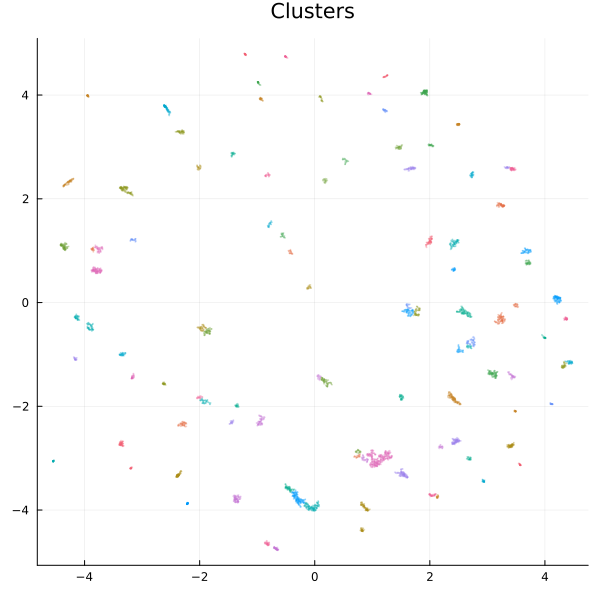

In [11]:
plot!(title="Clusters")


# Actividades
- Si usa Julia, revise el paquete `SimilaritySearch.jl`: <https://github.com/sadit/SimilaritySearch.jl> y <https://github.com/sadit/SimSearchManifoldLearning.jl>.
- Si usa Python, revise el paquete UMAP: <https://umap-learn.readthedocs.io/en/latest/>.
- Qué ventajas y desventajas tiene usar este método vs. otros métodos de clustering como $k$means.
- Prepare la colección de `noticias` o el `emojispace` con la representación semántica de SBERT, adicionalmente reproduzcalo para la representación basada en bolsa de palabras (primeras unidades del curso). Reproduzca las operaciones y el análisis de este notebook con estos datos.
- Reporte su notebook con una comparación de tiempos y calidadades.

# Bibliografía

- [@AW2019] Amid, E., & Warmuth, M. K. (2019). TriMap: Large-scale dimensionality reduction using triplets. arXiv preprint arXiv:1910.00204.
- [@LV2017] Lee, J. A., & Verleysen, M. (2007). Nonlinear dimensionality reduction (Vol. 1). New York: Springer.
- [@MHM2018] McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.
- [VSPU2017] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.
- [RG2020] Reimers, N., & Gurevych, I. (2020). Making monolingual sentence embeddings multilingual using knowledge distillation. arXiv preprint arXiv:2004.09813.
- [@SKL2011] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- [@SPA2019] Soto, A. J., Przybyła, P., & Ananiadou, S. (2019). Thalia: semantic search engine for biomedical abstracts. Bioinformatics, 35(10), 1799-1801.
- [@SS2021] Sharma, K. K., & Seal, A. (2021). Spectral embedded generalized mean based k-nearest neighbors clustering with S-distance. Expert Systems with Applications, 169, 114326.
- [@VMH2018] Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).
- [@YCC2020] Yu, Q., Chen, K. H., & Chen, J. J. (2020, September). Using a set of triangle inequalities to accelerate k-means clustering. In International Conference on Similarity Search and Applications (pp. 297-311). Springer, Cham.